In [88]:
# !pip install -q wandb
# !pip install datasets
# !pip install seqeval
# !pip install evaluate
# !pip install datasets transformers==4.28.0
# !pip install transformers[torch]
import pandas as pd
from datasets import load_dataset
import numpy as np
from transformers import AutoTokenizer
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer
from transformers import DataCollatorForTokenClassification
import evaluate
import matplotlib.pyplot as plt
import torch
from collections import Counter
from tqdm import tqdm
import wandb
import time



# Preprocess Data

## Loading in Inspec Dataset with samples

In [2]:
dataset = load_dataset("midas/inspec", "extraction")


print("Samples for Keyphrase Extraction\n")

# sample from the train split
print("Sample from training data split")
train_sample = dataset["train"][0]
print("Fields in the sample: ", [key for key in train_sample.keys()])
print("Tokenized Document: ", train_sample["document"])
print("Document BIO Tags: ", train_sample["doc_bio_tags"])
print("\n-----------\n")

# sample from the validation split
print("Sample from validation data split")
validation_sample = dataset["validation"][0]
print("Fields in the sample: ", [key for key in validation_sample.keys()])
print("Tokenized Document: ", validation_sample["document"])
print("Document BIO Tags: ", validation_sample["doc_bio_tags"])
print("\n-----------\n")

# sample from the test split
print("Sample from test data split")
test_sample = dataset["test"][0]
print("Fields in the sample: ", [key for key in test_sample.keys()])
print("Tokenized Document: ", test_sample["document"])
print("Document BIO Tags: ", test_sample["doc_bio_tags"])
print("\n-----------\n")
print('Type of each dataset:', type(dataset["train"]))

Repo card metadata block was not found. Setting CardData to empty.


Samples for Keyphrase Extraction

Sample from training data split
Fields in the sample:  ['id', 'document', 'doc_bio_tags']
Tokenized Document:  ['A', 'conflict', 'between', 'language', 'and', 'atomistic', 'information', 'Fred', 'Dretske', 'and', 'Jerry', 'Fodor', 'are', 'responsible', 'for', 'popularizing', 'three', 'well-known', 'theses', 'in', 'contemporary', 'philosophy', 'of', 'mind', ':', 'the', 'thesis', 'of', 'Information-Based', 'Semantics', '-LRB-', 'IBS', '-RRB-', ',', 'the', 'thesis', 'of', 'Content', 'Atomism', '-LRB-', 'Atomism', '-RRB-', 'and', 'the', 'thesis', 'of', 'the', 'Language', 'of', 'Thought', '-LRB-', 'LOT', '-RRB-', '.', 'LOT', 'concerns', 'the', 'semantically', 'relevant', 'structure', 'of', 'representations', 'involved', 'in', 'cognitive', 'states', 'such', 'as', 'beliefs', 'and', 'desires', '.', 'It', 'maintains', 'that', 'all', 'such', 'representations', 'must', 'have', 'syntactic', 'structures', 'mirroring', 'the', 'structure', 'of', 'their', 'contents', 

In [3]:
label_list = np.unique(train_sample["doc_bio_tags"])

id2label = {i: label for i, label in enumerate(label_list)}
label2id = {v: k for k, v in id2label.items()}

print('Mapping doc_bio_tag to integer:\n\n',label2id)
print('\nMapping integer to doc_bio_tag:\n\n',id2label)

Mapping doc_bio_tag to integer:

 {'B': 0, 'I': 1, 'O': 2}

Mapping integer to doc_bio_tag:

 {0: 'B', 1: 'I', 2: 'O'}


## Specifying the base model we want

In [63]:
#model_checkpoint = "distilroberta-base"
model_checkpoint = "distilbert-base-uncased"

In [64]:
#checking to see if we have gpus
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Pytorch version: {torch.__version__}")
    print(f"Device name: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("No GPU available.")

Pytorch version: 2.0.1+cu118
Device name: Tesla T4


## Getting the same tokenizer that was used in the pre-trained model to preprocess text

General Info:

A tokenizer breaks unstructured data and natural language text into chunks of information that can be considered as discrete elements.

We use add_prefix_space = True to specify that we want to add a space to the first word if there isn’t already one. This lets us treat 'hello' exactly like 'say hello'.

Although the documents are already tokenized, we want to make sure that the tokenization matches the one that our pre-trained model is expecting.

In [65]:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, add_prefix_space=True)
#check to make sure tokenizer has fast version available
tokenizer.is_fast

True

## Convert BIO tags of words to numerical labels (1,2, or 0) corresponding to tokens

Each word in the document gets converted into a token/multiple tokens. After the word is converted into a token we need to assign that token a classification index corresponding to the BIO tag of the word.  This is done with the function below.

see https://huggingface.co/docs/transformers/tasks/token_classification

In [66]:
def tokenize_words_with_corresponding_labels(sample):

    tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, add_prefix_space=True)

    #truncation=True to specify to truncate sequences at the maximum length
    #is_split_into_words = True to specify that our input is already pre-tokenized (e.g., split into words)
    tokenized_inputs = tokenizer(sample["document"], truncation=True, is_split_into_words=True)

    #initialize list to store lists of labels for each sample
    labels = []

    for i, label in enumerate(sample["doc_bio_tags"]):

        #map tokens to their respective word
        #word_ids() method gets index of the word that each token comes from
        word_ids = tokenized_inputs.word_ids(batch_index=i)

        #initialize list of labels for each token in a given sample
        label_ids = []

        for word_idx in word_ids:

            #set the special tokens, [CLS] and [SEP], to -100.
            # we use -100 because it's an index that is ignored in the loss function we will use (cross entropy).
            if word_idx is None:
                label_ids.append(-100)

            #set labels for tokens
            else:
                label_ids.append(label2id[label[word_idx]])

        labels.append(label_ids)

    tokenized_inputs["labels"] = labels

    return tokenized_inputs

In [67]:
tokenized_dataset = dataset.map(tokenize_words_with_corresponding_labels, batched=True)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

# Finetuning the model with the Trainer API

Token classification with NLP on HuggingFace info

https://huggingface.co/learn/nlp-course/chapter7/2

## Data collator to pad inputs sequences and labels

In [68]:
#dynamically pad the inputs received, as well as the labels to make them all the same length
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)


## Track metrics during training

To have the Trainer compute a metric every epoch, we will need to define a compute_metrics() function that takes the arrays of predictions and labels, and returns a dictionary with the metric names and values.

This compute_metrics() function takes the argmax of the logits to convert them to predictions. Then we have to convert both labels and predictions from integers to strings. We remove all the values where the label is -100, then pass the results to the metric.compute() method.

In [69]:
metric = evaluate.load("seqeval")

In [70]:
def compute_metrics(preds):
    logits, labels = preds
    predictions = np.argmax(logits, axis=-1)

    # Remove ignored index (special tokens) and convert to labels
    true_labels = [[id2label[l] for l in label if l != -100] for label in labels]

    true_predictions = [
        [id2label[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    all_metrics = metric.compute(predictions=true_predictions, references=true_labels)
    return all_metrics

## Weights and Biases Login

In [90]:
# Login to W&B account
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

## Defining the model

In [71]:
#hacky way to get around AttributeError: module 'torch.distributed' has no attribute 'is_initialized' error
#setattr(torch.distributed, "is_initialized", lambda : False)

In [93]:
torch.manual_seed(0)
model_name = model_checkpoint.split("/")[-1]


model = AutoModelForTokenClassification.from_pretrained(model_checkpoint,
                                                        id2label=id2label,
                                                        label2id=label2id)
#need GPU to train
_ = model.to(device)

#check to make sure we have three labels for outputs
print('Number of labels:', model.config.num_labels)


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForTokenClassification: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream

Number of labels: 3


In [97]:
batch_size = 8
learning_rate=4e-6

num_epochs = 6
args = TrainingArguments(
    f"{model_name}_finetuned_keyword_extract",
    evaluation_strategy = "epoch",
    logging_strategy = 'epoch',
    learning_rate=learning_rate,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs= num_epochs,
    lr_scheduler_type='linear',
    weight_decay=0.01,
    seed=0
)

## Define a custom loss using weighted crossentropy

In [98]:
#counting how many beginning keywords, middle keywords, and non-keywords there are
count_0s = 0
count_1s = 0
count_2s = 0

for listt in tokenized_dataset["train"]["labels"]:
    count_dict = Counter(listt)
    count_0s += count_dict[0]
    count_1s += count_dict[1]
    count_2s += count_dict[2]

#getting weights for weighted cross_entropy
max_ = max(count_0s,count_1s,count_2s)
weights = [max_/count_0s, max_/count_1s, max_/count_2s]

#defining loss function
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels").to(model.device)
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get("logits").to(model.device)
        # compute custom loss (suppose one has 3 labels with different weights)
        loss_fct = torch.nn.CrossEntropyLoss(weight= torch.tensor(weights).to(device))
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

## Launch training

In [99]:
# Initialize a W&B run
wandb.init(
    project = 'ppp-keyword-extraction',
    config = {
      "learning_rate": learning_rate,
      "epochs": epochs,
      "batch_size": batch_size,
      "model_name": model_name
    },
    name = model_name
)


# Train model
start_time = time.time()


trainer = CustomTrainer(
    model=model,
    args=args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer)
trainer.train()

execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

# Update W&B
wandb.config.update({"execution_time": execution_time})
# Close the W&B run
wandb.run.finish()

wandb: Currently logged in as: caleb-b-saul (ac215-ppp). Use `wandb login --relogin` to force relogin


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,,Overall Precision,Overall Recall,Overall F1,Overall Accuracy
1,0.813200,0.563476,"{'precision': 0.22080031180979603, 'recall': 0.5934008379888268, 'f1': 0.32184452229902477, 'number': 5728}",0.220800,0.593401,0.321845,0.778330
2,0.477600,0.434292,"{'precision': 0.26813682495927826, 'recall': 0.7472067039106145, 'f1': 0.3946519133241124, 'number': 5728}",0.268137,0.747207,0.394652,0.776157
3,0.407200,0.404173,"{'precision': 0.29357077386408276, 'recall': 0.7828212290502793, 'f1': 0.42700695171888386, 'number': 5728}",0.293571,0.782821,0.427007,0.792510
4,0.377900,0.390018,"{'precision': 0.305846071332797, 'recall': 0.7964385474860335, 'f1': 0.44196861073435384, 'number': 5728}",0.305846,0.796439,0.441969,0.797812
5,0.362200,0.383535,"{'precision': 0.3099871177706963, 'recall': 0.7981843575418994, 'f1': 0.44654978756653807, 'number': 5728}",0.309987,0.798184,0.446550,0.800780
6,0.352200,0.381921,"{'precision': 0.30797636632200887, 'recall': 0.8008030726256983, 'f1': 0.44486470759383173, 'number': 5728}",0.307976,0.800803,0.444865,0.799389


Trainer is attempting to log a value of "{'precision': 0.22080031180979603, 'recall': 0.5934008379888268, 'f1': 0.32184452229902477, 'number': 5728}" of type <class 'dict'> for key "eval/_" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.26813682495927826, 'recall': 0.7472067039106145, 'f1': 0.3946519133241124, 'number': 5728}" of type <class 'dict'> for key "eval/_" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.29357077386408276, 'recall': 0.7828212290502793, 'f1': 0.42700695171888386, 'number': 5728}" of type <class 'dict'> for key "eval/_" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.305846071332797, 'recall': 0.7964385474860335, 

Training execution time (mins) 3.8297812422116597


eval/loss,█▃▂▁▁▁
eval/overall_accuracy,▂▁▆▇██
eval/overall_f1,▁▅▇███
eval/overall_precision,▁▅▇███
eval/overall_recall,▁▆▇███
eval/runtime,▂█▁▁▆▁
eval/samples_per_second,▇▁██▃█
eval/steps_per_second,▇▁██▃█
train/epoch,▁▁▂▂▄▄▅▅▇▇███
train/global_step,▁▁▂▂▄▄▅▅▇▇███
train/learning_rate,█▇▅▄▂▁


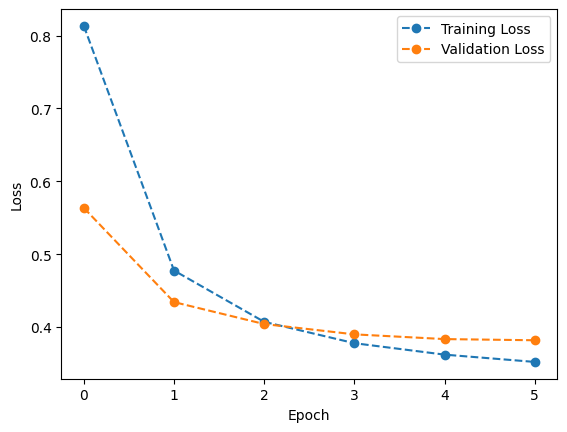

In [100]:
loss = []
val_loss = []
for d in trainer.state.log_history:
    if "loss" in d:
        loss.append(d["loss"])
    if "eval_loss" in d:
        val_loss.append(d["eval_loss"])

plt.plot(range(num_epochs), loss, 'o--')
plt.plot(range(num_epochs), val_loss, 'o--')
plt.legend(["Training Loss", "Validation Loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

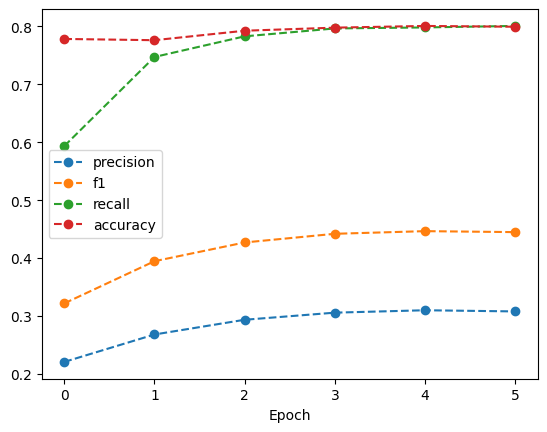

In [80]:
eval_overall_precision = []
eval_overall_f1 = []
eval_overall_recall = []
eval_overall_accuracy = []


for d in trainer.state.log_history:
    if "eval_overall_precision" in d:
        eval_overall_precision.append(d["eval_overall_precision"])
        eval_overall_f1.append(d["eval_overall_f1"])
        eval_overall_recall.append(d["eval_overall_recall"])
        eval_overall_accuracy.append(d["eval_overall_accuracy"])

plt.plot(range(num_epochs), eval_overall_precision,'o--', label = 'precision')
plt.plot(range(num_epochs), eval_overall_f1, 'o--',label = 'f1')
plt.plot(range(num_epochs), eval_overall_recall, 'o--',label = 'recall')
plt.plot(range(num_epochs), eval_overall_accuracy, 'o--',label = 'accuracy')
plt.legend()
plt.xlabel("Epoch")
plt.show()

## Test Set Performance

In [81]:
test_output = trainer.evaluate(tokenized_dataset["test"])
test_output

Trainer is attempting to log a value of "{'precision': 0.32885635618830167, 'recall': 0.8290164211951921, 'f1': 0.47091066448696994, 'number': 5907}" of type <class 'dict'> for key "eval/_" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


{'eval_loss': 0.35649117827415466,
 'eval__': {'precision': 0.32885635618830167,
  'recall': 0.8290164211951921,
  'f1': 0.47091066448696994,
  'number': 5907},
 'eval_overall_precision': 0.32885635618830167,
 'eval_overall_recall': 0.8290164211951921,
 'eval_overall_f1': 0.47091066448696994,
 'eval_overall_accuracy': 0.8097503561915381,
 'eval_runtime': 7.4798,
 'eval_samples_per_second': 66.847,
 'eval_steps_per_second': 8.423,
 'epoch': 6.0}

## Function to extract keyphrases on a sample text

In [82]:
def extract_keyphrases(text, model, tokenizer, text_in_list = False):

    if text_in_list:
        text = ' '.join(word for word in text)

    inputs = tokenizer(text,return_tensors="pt")["input_ids"].to(device)
    with torch.no_grad():
        logits = model(inputs).logits

    predictions = torch.argmax(logits, dim=2)
    predicted_token_class = [model.config.id2label[t.item()] for t in predictions[0]]

    keyphrases = []
    keyphrase = []
    for label, token in zip(predicted_token_class, inputs[0]):
        if label == 'B':
            keyphrase = []
            keyphrase.append(tokenizer.decode(token))
        elif label == 'I' and len(keyphrase) > 0:
            keyphrase.append(tokenizer.decode(token))

        elif label == 'O' and len(keyphrase) > 0:
            keyphrases.append(keyphrase)
            keyphrase = []

    return keyphrases

## Sample Text

In [83]:
' '.join(word for word in dataset["test"][0]["document"])

'A new graphical user interface for fast construction of computation phantoms and MCNP calculations : application to calibration of in vivo measurement systems Reports on a new utility for development of computational phantoms for Monte Carlo calculations and data analysis for in vivo measurements of radionuclides deposited in tissues . The individual properties of each worker can be acquired for a rather precise geometric representation of his -LRB- her -RRB- anatomy , which is particularly important for low energy gamma ray emitting sources such as thorium , uranium , plutonium and other actinides . The software enables automatic creation of an MCNP input data file based on scanning data . The utility includes segmentation of images obtained with either computed tomography or magnetic resonance imaging by distinguishing tissues according to their signal -LRB- brightness -RRB- and specification of the source and detector . In addition , a coupling of individual voxels within the tissu

## Model Generated Key Phrases

In [84]:
extract_keyphrases(dataset["test"][0]["document"], model, tokenizer, True)

[['graphical', 'user', 'interface'],
 ['fast', 'construction'],
 ['computation', 'phantom', '##s'],
 ['##np', 'calculations'],
 ['##ration'],
 ['vivo', 'measurement', 'systems'],
 ['computational', 'phantom', '##s'],
 ['carlo', 'calculations'],
 ['data', 'analysis'],
 ['vivo', 'measurements'],
 ['##ides', 'deposited'],
 ['tissues'],
 ['worker'],
 ['geometric', 'representation'],
 ['low', 'energy', 'gamma', 'ray', 'emi', '##tting', 'sources'],
 ['##ium'],
 ['uranium'],
 ['##nium'],
 ['##des'],
 ['##np', 'input', 'data', 'file'],
 ['scanning', 'data'],
 ['##ation'],
 ['images'],
 ['computed', 'tom', '##ography'],
 ['magnetic', 'resonance', 'imaging'],
 ['tissues'],
 ['detector'],
 ['vox', '##els'],
 ['tissue'],
 ['memory', 'demand'],
 ['calculation'],
 ['low', 'energy', 'emi', '##tters'],
 ['plastic'],
 ['biological', 'tissues'],
 ['computed', 'tom', '##ography'],
 ['magnetic', 'resonance', 'imaging', 'scanning', 'information']]

## Actual key words from the sample text

In [86]:
keyphrases = []
keyphrase = []
for label, word in zip(dataset["test"][0]["doc_bio_tags"],dataset["test"][0]["document"]):
    if label == 'B':
        keyphrase = []
        keyphrase.append(word)
    elif label == 'I' and len(keyphrase) > 0:
        keyphrase.append(word)

    elif label == 'O' and len(keyphrase) > 0:
        keyphrases.append(keyphrase)
        keyphrase = []
keyphrases

[['graphical', 'user', 'interface'],
 ['computation', 'phantoms'],
 ['calibration'],
 ['in', 'vivo', 'measurement', 'systems'],
 ['computational', 'phantoms'],
 ['Monte', 'Carlo', 'calculations'],
 ['in', 'vivo', 'measurements'],
 ['radionuclides'],
 ['tissues'],
 ['worker'],
 ['precise', 'geometric', 'representation'],
 ['anatomy'],
 ['low', 'energy', 'gamma', 'ray', 'emitting', 'sources'],
 ['actinides'],
 ['software'],
 ['automatic', 'creation'],
 ['MCNP', 'input', 'data', 'file'],
 ['scanning', 'data'],
 ['computed', 'tomography'],
 ['tissues'],
 ['signal'],
 ['brightness'],
 ['detector'],
 ['individual', 'voxels'],
 ['memory', 'demand'],
 ['calculational', 'speed'],
 ['plastic'],
 ['tissues'],
 ['computed', 'tomography']]

## Tomorrow

- make code modular
- get it running with weights and biases for 3 different base model instead of one at a time
- convert notebook into python script with one container for preprocessing and one for training
- make it multi-gpu compatible